### import python package

In [14]:
# import python package
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import  math

### dataset

In [2]:
class single_model_dataset(Dataset):
    def __init__(self, features, label):
        self.features = features
        self.label = label
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # 從 data DataFrame 中提取特徵，並轉換為 PyTorch Tensor
        features = torch.tensor(self.features[idx].iloc[:, [2, 3, 4, 5]].values, dtype=torch.float32)
        
        # 從 label DataFrame 中提取標籤，並轉換為 PyTorch Tensor
        label = torch.tensor(self.label[idx]['Close'], dtype=torch.float32)  # 假設標籤為整數型態
        return features, label

In [4]:
def price_normalization(price_data):
    digits = int(math.log10(max(list(price_data['High']))))
    normalize_number = math.pow(10, digits)
    normalize_columns = price_data[['Open', 'High', 'Close', 'Low']]/normalize_number
    price_data[['Open', 'High', 'Close', 'Low']] = normalize_columns[['Open', 'High', 'Close', 'Low']]
    
    return price_data


def split_training_teseting_dataset(df, train_date, test_date):  
    # get index
    for i in range(len(df)):
        if df['Date'][i] == train_date:
            train_start_index = i
            
        elif df['Date'][i] == test_date:
            test_start_index = i  
    # split training / testing
    train_dataset = df.iloc[train_start_index:test_start_index].reset_index(drop=True)
    test_dataset = df.iloc[test_start_index:].reset_index(drop=True)
    return train_dataset, test_dataset

def split_dataset_xy(data, window_size, datatype):
    x = []
    y = []
    
    if datatype=='nparray':
        for i in range(len(data)-window_size):
            x.append(data[i:i+window_size,:])
            y.append(data[i+window_size,:])
        return x,y            
    
    elif datatype=='dataframe':
        for i in range(len(data)-window_size):
            x.append(data.iloc[i:i+window_size,:])
            y.append(data.iloc[i+window_size,:])
        return x,y    

In [6]:
# read data
DASH_price = pd.read_csv('/Users/welcome870117/Desktop/git_project/finance-project/paper_implement/DL-GuesS/dataset/DASH_dataset.csv', index_col = False)
# data normalization 
DASH_price_n = price_normalization(DASH_price)
# split trainset, testset
training_dataset, testing_dataset = split_training_teseting_dataset(DASH_price_n, '2014-02-14', '2023-04-01')
# get dataset x, y
train_x, train_y = split_dataset_xy(training_dataset, 5, 'dataframe')
test_x, test_y = split_dataset_xy(testing_dataset, 5, 'dataframe')
# torch dataset
dataset_single = single_model_dataset(train_x, train_y)
dataset_single_test = single_model_dataset(test_x, test_y)
# torch dataloader
dataset_single_dataloader = DataLoader(dataset_single,  batch_size=16, shuffle=False)
dataset_single_test_dataloader = DataLoader(dataset_single_test,  batch_size=1, shuffle=False)

### LSTM model

In [18]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=4,   # 输入尺寸为 1，表示一天的数据
            hidden_size=64,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        out = self.out(r_out[:, -1, :])          # 取最后一天作为输出
        
        return out

In [16]:
LR = 0.0001
EPOCH = 50
TRAIN_END=-300
DAYS_BEFORE=7

In [19]:
# 
model = LSTM()
# loss
criterion = torch.nn.MSELoss(reduction='mean')
#  optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=LR)

for t in range(EPOCH):
    total_loss = []
    sum_loss = 0
    for i,data in enumerate(dataset_single_dataloader):
        feature, label = data           
        model_predict = model(feature)
        loss = criterion(model_predict,label)
        sum_loss+=loss
        total_loss.append(sum_loss)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step() 
    print('total_loss:',sum_loss)

/Users/welcome870117/opt/anaconda3/envs/trading/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total_loss: tensor(5.2082, grad_fn=<AddBackward0>)
total_loss: tensor(4.2973, grad_fn=<AddBackward0>)
total_loss: tensor(3.3243, grad_fn=<AddBackward0>)
total_loss: tensor(2.2819, grad_fn=<AddBackward0>)
total_loss: tensor(1.2621, grad_fn=<AddBackward0>)
total_loss: tensor(0.5348, grad_fn=<AddBackward0>)
total_loss: tensor(0.2940, grad_fn=<AddBackward0>)
total_loss: tensor(0.2766, grad_fn=<AddBackward0>)
total_loss: tensor(0.2730, grad_fn=<AddBackward0>)
total_loss: tensor(0.2698, grad_fn=<AddBackward0>)
total_loss: tensor(0.2677, grad_fn=<AddBackward0>)
total_loss: tensor(0.2662, grad_fn=<AddBackward0>)
total_loss: tensor(0.2655, grad_fn=<AddBackward0>)
total_loss: tensor(0.2653, grad_fn=<AddBackward0>)
total_loss: tensor(0.2655, grad_fn=<AddBackward0>)
total_loss: tensor(0.2660, grad_fn=<AddBackward0>)
total_loss: tensor(0.2666, grad_fn=<AddBackward0>)
total_loss: tensor(0.2674, grad_fn=<AddBackward0>)
total_loss: tensor(0.2682, grad_fn=<AddBackward0>)
total_loss: tensor(0.2689, grad

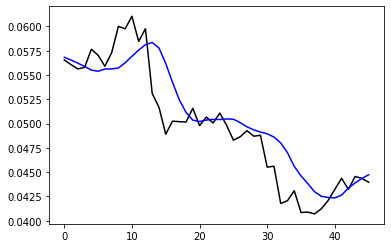

In [20]:
model_predict = []
real_price = []
for i,data in enumerate(dataset_single_test_dataloader):
    features, label = data
    predict = model(features)
    model_predict.append(predict.detach().numpy().reshape(-1,)[0])  
    real_price.append(label.detach().numpy().reshape(-1,)[0])


plt.plot(real_price, c='black')
plt.plot(model_predict, c='blue')